In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# name of the notebook
name_notebook = "sweep_12h_e_Am_Xqm"

In [4]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="Try to find the best measurement and number of layers for the quantum block using Amplitude Encoding and embedding.",
#     repetitions=list(range(1, 3)),
#     n_layers_quantum_block=[1,2,5,12,20],
#     n_qubits=[4,6],
#     qubits_measurement=[1, 'all'],
# )

In [5]:
# sweep.save()

In [6]:
sweep = c.Sweep.load(file_name=name_notebook+"-1", day='0912', initial_path=initial_path)



 --- SWEEP POINT 1/40: (1, 1, 4, 1) ---
 --- parameters sweeping: ['repetitions', 'n_layers_quantum_block', 'n_qubits', 'qubits_measurement'] 

Epoch [0/2], Loss epoch: 0.3548, Loss validation: 0.3554


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 3173; 	 prediction: -0.1521, 	 target: -0.2330, 	 loss: 0.0065
	 Validation string, 	 i: 1610; 	 prediction: -0.4016, 	 target: -0.4729, 	 loss: 0.0051
	 Validation string, 	 i: 3676; 	 prediction: -0.2794, 	 target: -0.1398, 	 loss: 0.0195
Epoch [1/2], Loss epoch: 0.0138, Loss validation: 0.0129, Time remaining: ~0.0h 5.0m 45s
	 Validation string, 	 i: 4289; 	 prediction: -0.1651, 	 target: -0.0004, 	 loss: 0.0271
	 Validation string, 	 i: 1469; 	 prediction: -0.2385, 	 target: -0.3059, 	 loss: 0.0045
	 Validation string, 	 i: 3386; 	 prediction: -0.1566, 	 target: -0.1191, 	 loss: 0.0014
Epoch [2/2], Loss epoch: 0.0123, Loss validation: 0.0120, Time remaining: ~0.0h 0.0m 0s


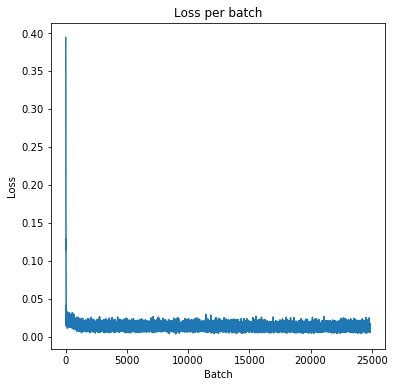

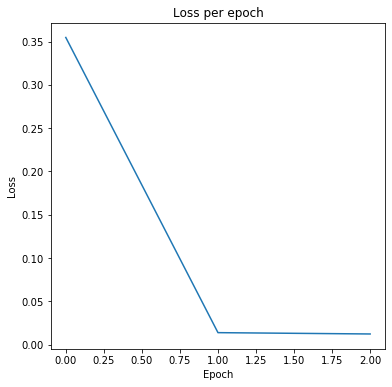

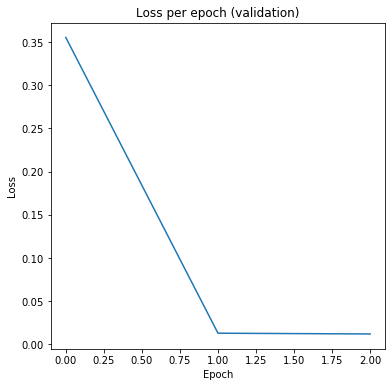

In [7]:
for sweep_point in sweep:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = sweep_point['n_qubits']
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AmplitudeEmbedding, 
        # embedding_ansatz = q.parts.Ansatz_11,
        block_ansatz = q.parts.Ansatz_11,
        final_ansatz = q.parts.Ansatz_11,
        measurement = q.parts.Measurement('Z', sweep_point['qubits_measurement']),
        # embedding_n_layers = 4,
        # different_inputs_per_layer = True,
        block_n_layers = sweep_point['n_layers_quantum_block'],
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            n_qubits_measured = n_qubits if sweep_point['qubits_measurement'] == 'all' else 1
            embedding_dim = 2**n_qubits//12
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=embedding_dim)
            self.fc2 = m.Reshape()
            self.fc3 = quantum_layer() 
            self.fc4 = m.nn.Linear(n_qubits_measured, n_qubits_measured) 
            self.fc5 = m.nn.Linear(n_qubits_measured, 1)

        def forward(self, x):
            x = self.fc1(x)
            x = self.fc2(x)
            x = self.fc3(x)
            x = m.torch.sigmoid(self.fc4(x))
            x = self.fc5(x)
            return x

    model = Model()

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 12 amino acids and {} qubits using Amplitude Encoding and classical Embedding'.format(n_qubits),    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 2,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    